In [116]:
import pandas as pd
import numpy as np
import matplotlib as plt
import datetime

In [117]:
calendar = pd.read_csv('./seattle/calendar.csv')
listings = pd.read_csv('./seattle/listings.csv')
reviews = pd.read_csv('./seattle/reviews.csv')

# Calendar 

In [118]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [121]:
calendar.dtypes

listing_id             int64
date          datetime64[ns]
available             object
price                 object
dtype: object

In [120]:
calendar['date'] = pd.to_datetime(calendar['date'], format = '%Y-%m-%d')

In [122]:
#check if all listing ids have the same number of dates

count_dates = calendar[['listing_id','date']].groupby('listing_id').count()
count_dates['date'].unique()

array([365], dtype=int64)

In [123]:
calendar.available.unique()

array(['t', 'f'], dtype=object)

In [124]:
# replace 'available' column data with numeric binary data
try:
    calendar['available'] = calendar['available'].replace({'t':1,'f':0})
except:
    pass
calendar.available.unique()

array([1, 0], dtype=int64)

In [ ]:
calendar = calendar.set_index('date')


In [135]:
calendar_16 = calendar[calendar.index < datetime.datetime.strptime('2017-01-01', '%Y-%m-%d')]


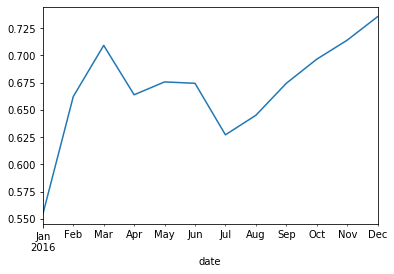

In [139]:

calendar_availability16 = calendar_16[['available']].groupby(pd.Grouper(freq="M")).mean()

calendar_availability16.available.plot(kind = 'line');




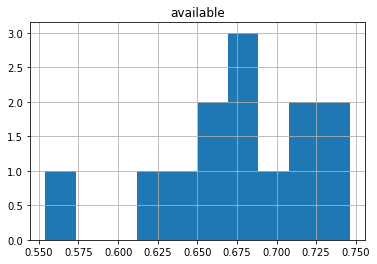

In [130]:
calendar_availability = calendar[['date','available']].groupby('date',as_index=False).sum()

calendar_occupancy_bf17 = calendar_availability[calendar_availability.date < datetime.datetime.strptime('2017-01-01', '%Y-%m-%d')]

calendar_occupancy_bf17['date'] = pd.to_datetime(calendar_occupancy_bf17['date'],format='%y-%m-d')


# Reviews

In [8]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [75]:
listings.keys()

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

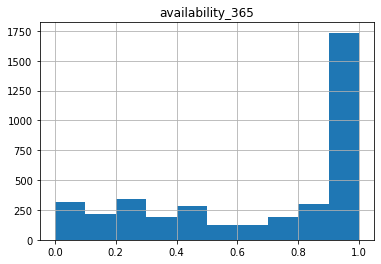

In [84]:
(listings[['availability_365']]/365).hist();